In [1]:
import datetime
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from config import decimal0,decimal1,tick_data_path
from utils import fun
import utils
import math
import scipy.stats as st
import statsmodels.api as sm


os.chdir(os.path.abspath(os.path.join(os.getcwd(),"..")))
print(os.getcwd())


/Users/hou/Documents/work/research


In [2]:
start_date = "2021-12-22"
end_date = "2022-10-13"

dates = pd.date_range(start_date, end_date).strftime("%Y-%m-%d").to_list()


In [3]:
swap = pd.DataFrame()
vola = pd.DataFrame()
vola['date'] = dates
vola.index = dates

df_daym = pd.DataFrame()
df_daym['minute'] = range(0,60*24)

In [4]:
mint = pd.DataFrame()
burn = pd.DataFrame()
last = pd.DataFrame()

In [5]:
# Get data
from config import tick_data_path
import os
print(os.getcwd())

for i in range(1, len(dates)):
    # update last date close info
    date = dates[i]
    print(date)
    
    # get daily dataset
    try:
        data_path = tick_data_path + date + ".csv"
        data = pd.read_csv(data_path, sep=',', index_col=None, dtype=object, header=0)
    except Exception as e:
        print(e)
        continue
    data[['amount0','amount1','current_tick',"tick_lower","tick_upper",'current_liquidity']] = data[['amount0','amount1','current_tick',"tick_lower","tick_upper",'current_liquidity']].astype(float)
    data[['current_tick']] = data[['current_tick']].astype('Int64')
    data.loc[:, "block_timestamp"] = data.loc[:, "block_timestamp"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
    data['date'] = date
    
    df_mint = data.loc[data['tx_type'].str.contains('MINT')]
    df_burn = data.loc[data['tx_type'].str.contains('BURN')]    
    
    if i == 1:
        data_path = tick_data_path + dates[0] + ".csv"
        last_data = pd.read_csv(data_path, sep=',', index_col=None, dtype=object, header=0)
        last_data[['current_tick','current_liquidity']] = last_data[['current_tick','current_liquidity']].astype(float)
        last_data[['current_tick']] = last_data[['current_tick']].astype('Int64')
        last_date_end = last_data.iloc[len(last_data) - 1,[10,11,12]].to_frame().T
        date_end = data.iloc[len(data)-1,[10,11,12]].to_frame().T
        last = pd.concat([last, last_date_end])
        last = pd.concat([last, date_end])
    else:
        date_end = data.iloc[len(data) - 1, [10,11,12]].to_frame().T
        # fill in missing data in mint & burn
        for i in range(0, len(df_mint) - 1):
            if pd.isnull(df_mint.iloc[i,10]):
                df_mint.iloc[i, [10,11,12]] = last_date_end.iloc[0, :]
            else:
                break
                
        for i in range(0, len(df_burn) - 1):
            if pd.isnull(df_burn.iloc[i,10]):
                df_burn.iloc[i, [10,11,12]] = last_date_end.iloc[0, :]
            else:
                break
        last = pd.concat([last, date_end])
        last_date_end = date_end
    
    # compute volumn
    df_swap = data.loc[data['tx_type'].str.contains('SWAP'), ['block_timestamp', 'amount0','current_tick','current_liquidity','date']]
    d0 = datetime.datetime.strptime(date+' 0:00:0', "%Y-%m-%d %H:%M:%S")
    df_swap['amount0'] = df_swap['amount0'] / (10**(decimal0))
    df_swap['vol'] = df_swap['amount0'].apply(lambda x: abs(x))                      
    df_swap['minute'] = df_swap['block_timestamp'].apply(lambda x: ((x - d0).seconds//60))
                                              
    # compute daily historical volatility
    swap1 = df_swap.loc[:,['minute','current_tick']]
    swap1 = swap1.drop_duplicates(['minute'], keep='last')
    swap1 = pd.merge(df_daym, swap1, how='left',left_on='minute', right_on='minute')
                                              
    if pd.isnull(swap1.iloc[0,1]): # have no transaction at 0:00 
        swap1.iloc[0,1] = last_date_end.iloc[0,2]
    swap1.fillna(method='ffill', inplace=True) # have no transaction at other time points
    
    df = pd.DataFrame({'minute':[-1],
                       'current_tick':[last_date_end.iloc[0,2]]},index=[-1])
    swap1 = pd.concat([df,swap1]) 
    swap1['current_price'] = swap1['current_tick'].map(fun)
    swap1['vola'] = swap1['current_price'].pct_change(1).fillna(0)
    swap1 = swap1.drop(-1)
    vola.loc[date, 'vola'] = np.std(swap1['vola'])

    mint = pd.concat([mint, df_mint])
    burn = pd.concat([burn, df_burn])
    swap = pd.concat([swap, df_swap])

print(vola.head(5))

/Users/hou/Documents/work/research
2021-12-23
2021-12-24
2021-12-25
2021-12-26
2021-12-27
2021-12-28
2021-12-29
2021-12-30
2021-12-31
2022-01-01


/Users/hou/.conda/envs/DeepDex/lib/python3.8/site-packages/pandas/core/indexing.py:1700: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, v, pi)


2022-01-02
2022-01-03
2022-01-04
2022-01-05
2022-01-06
2022-01-07
2022-01-08
2022-01-09
2022-01-10
2022-01-11
2022-01-12
2022-01-13
2022-01-14
2022-01-15
2022-01-16
2022-01-17
2022-01-18
2022-01-19
2022-01-20
2022-01-21
2022-01-22
2022-01-23
2022-01-24
2022-01-25
2022-01-26
2022-01-27
2022-01-28
2022-01-29
2022-01-30
2022-01-31
2022-02-01
2022-02-02
2022-02-03
2022-02-04
2022-02-05
2022-02-06
2022-02-07
2022-02-08
2022-02-09
2022-02-10
2022-02-11
2022-02-12
2022-02-13
2022-02-14
2022-02-15
2022-02-16
2022-02-17
2022-02-18
2022-02-19
2022-02-20
2022-02-21
2022-02-22
2022-02-23
2022-02-24
2022-02-25
2022-02-26
2022-02-27
2022-02-28
2022-03-01
2022-03-02
2022-03-03
2022-03-04
2022-03-05
2022-03-06
2022-03-07
2022-03-08
2022-03-09
2022-03-10
2022-03-11
2022-03-12
2022-03-13
2022-03-14
2022-03-15
2022-03-16
2022-03-17
2022-03-18
2022-03-19
2022-03-20
2022-03-21
2022-03-22
2022-03-23
2022-03-24
2022-03-25
2022-03-26
2022-03-27
2022-03-28
2022-03-29
2022-03-30
2022-03-31
2022-04-01
2022-04-02

vola: 每日的分钟级波动率
volumn usdc： 计价的每日交易量
fee： 万五的手续费收入

In [6]:
vola = vola.drop(start_date)
vola['avg5'] = vola['vola'].rolling(5, min_periods=1).sum()
vola['volumn'] = swap.groupby('date')['vol'].sum()
vola['fee'] = vola['volumn']*0.0005


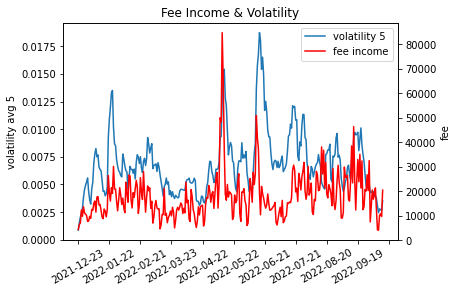

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

ln1 = ax.plot(vola['avg5'])
ax.set_ylabel('volatility avg 5')
plt.xticks(rotation=30)

ax2 = ax.twinx()
ln2 = ax2.plot(vola['fee'],'r')
ax2.set_ylabel('fee')

lns = ln1 + ln2
# labs = [l.get_label() for l in lns]
labs = ['volatility 5','fee income']
ax.legend(lns, labs, loc=0)

ax0 = plt.gca()
ax0.xaxis.set_major_locator(ticker.MultipleLocator(30))
plt.title('Fee Income & Volatility')
plt.show()

手续费与波动率有很强相关性

In [10]:
mint.head(3)

,block_number,transaction_hash,block_timestamp,pool_tx_index,pool_log_index,tx_type,sender,receipt,amount0,amount1,sqrtPriceX96,current_liquidity,current_tick,tick_lower,tick_upper,delta_liquidity,position_id,date
807,22851870,0x00c2f4135211ae11e986b824f59e523033f1e81640cb...,2021-12-23 02:57:59,48,318,MINT,0xc36442b4a4522e871399cd717abdd847ab11fe88,NaN,5.822057e+08,2.247000e+17,1256321324788037783847774141357472,2.667529e+16,193437,193140.0,193630.0,961375284808147.0,1099.0,2021-12-23
819,22851937,0x8f4db90e734e80e7101c3247c6e9949fe1f12398edea...,2021-12-23 03:00:17,37,326,MINT,0xc36442b4a4522e871399cd717abdd847ab11fe88,NaN,5.214599e+08,7.336582e+17,1257384995536224474107781990077064,5.394878e+16,193453,193420.0,193460.0,2.7273497828438404e+16,1112.0,2021-12-23
830,22851997,0x6329696284cf8905bf3f71ddb72872f896e34eb3b000...,2021-12-23 03:02:21,50,346,MINT,0xc36442b4a4522e871399cd717abdd847ab11fe88,NaN,1.079992e+09,9.440076e+17,1257204458497493969813286261936578,9.228981e+16,193451,193420.0,193460.0,3.834102805322085e+16,1112.0,2021-12-23


In [14]:
# mint[[ "position_id"]] = \
#     mint[["position_id"]].astype("Int64")

mint[["tick_lower","tick_upper", "position_id"]] = mint[["tick_lower","tick_upper", "position_id"]].astype(str).astype(float).astype('Int64')

mint = mint.reset_index()
del mint['index']
mint['current_price'] = mint['current_tick'].map(fun)
mint['price_lower'] = mint['tick_upper'].map(fun)
mint['price_upper'] = mint['tick_lower'].map(fun)
mint['liquidity'] = mint.apply(lambda x: utils.get_liquidity(x['current_tick'], x['tick_lower'], x['tick_upper'],
                                                              x['amount0'], x['amount1'],), axis=1)
mint["mean_ratio"] = mint.apply(lambda x: utils.compute_mean_ratio(x), axis=1)
mint["log_lq"] = mint["liquidity"].apply(lambda x: math.log((x+1),10))

block_number                 object
transaction_hash             object
block_timestamp      datetime64[ns]
pool_tx_index                object
pool_log_index               object
tx_type                      object
sender                       object
receipt                      object
amount0                     float64
amount1                     float64
sqrtPriceX96                 object
current_liquidity           float64
current_tick                  Int64
tick_lower                    Int64
tick_upper                    Int64
delta_liquidity              object
position_id                   Int64
date                         object
current_price               float64
price_lower                 float64
price_upper                 float64
liquidity                   float64
mean_ratio                  float64
log_lq                      float64
dtype: object

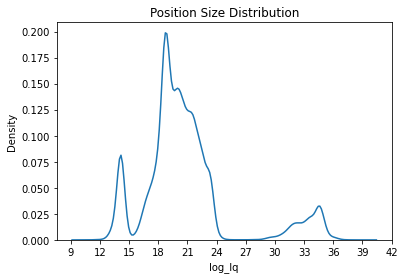

In [15]:
sns.kdeplot(mint["log_lq"])
plt.title("Position Size Distribution")
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(3))
plt.show()

LP头寸可以通过Liquidity大小分为三组：
小于10^15：小额投资人
10^15~10^27：普通投资人
大于10^27：专业投资人

我们将分组看三种不同投资人，在创建LP头寸时对上下界的设置有什么特征。以此来探究其动机和目的。

In [16]:
mint['label_size'] = mint['log_lq'].map(utils.fun_size)
mint.dtypes

block_number                 object
transaction_hash             object
block_timestamp      datetime64[ns]
pool_tx_index                object
pool_log_index               object
tx_type                      object
sender                       object
receipt                      object
amount0                     float64
amount1                     float64
sqrtPriceX96                 object
current_liquidity           float64
current_tick                  Int64
tick_lower                    Int64
tick_upper                    Int64
delta_liquidity              object
position_id                   Int64
date                         object
current_price               float64
price_lower                 float64
price_upper                 float64
liquidity                   float64
mean_ratio                  float64
log_lq                      float64
label_size                    int64
dtype: object

In [17]:
print(mint.loc[:,['price_upper','price_lower']].quantile([0,.005,.995,1]))
idx = mint[(mint.price_upper>7003) | 
           (mint.price_upper<919) | 
           (mint.price_lower>3886) | 
           (mint.price_lower<112)].index.values
mint98 = mint.drop(idx)
print(mint98.loc[:,['price_upper','price_lower']].quantile([0,1]))

        price_upper   price_lower
0.000  1.574569e-08  2.939545e-27
0.005  9.197128e+02  1.123762e+02
0.995  7.002062e+03  3.885432e+03
1.000  3.401887e+50  1.526348e+15
     price_upper  price_lower
0.0   919.712799   122.139324
1.0  7002.061981  3885.431797


上下界存在异常值，出现2.939545e-27， 3.401887e+50的极端值。
从分位数来看我们可以保留98%~99%的数据，并清除极端值。
极端值可能是用户随意设置的。

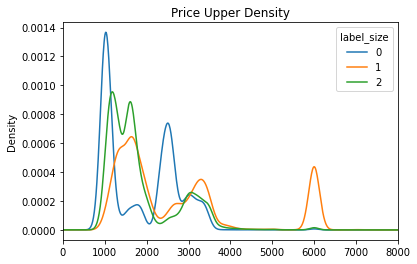

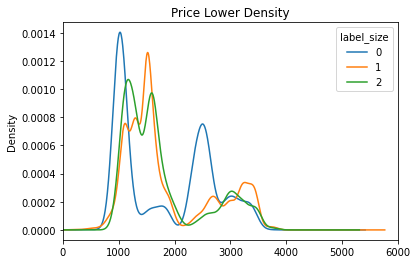

In [28]:
mint_up_size = mint98.pivot(columns='label_size', values='price_upper')
mint_low_size = mint98.pivot(columns='label_size', values='price_lower')


ax = mint_up_size.plot.density()
ax.set_xlim(0,8000)
ax.title.set_text('Price Upper Density')

ax2=mint_low_size.plot.density()
ax2.set_xlim(0,6000)
ax2.title.set_text('Price Lower Density')


可能有一部分普通投资人使用uniswap前端进行投资，在设置的时候选择6000这个整数。

In [29]:
burn[[ "position_id"]] = \
    burn[["position_id"]].astype(float)

burn[["position_id"]] = \
    burn[["position_id"]].astype('Int64')


In [30]:
mint_time = mint.loc[:,['transaction_hash','block_timestamp','position_id','label_size']]
print("mint shape", mint_time.shape)
mint_time = mint_time.dropna(axis=0)
print("mint shape, drop posid=na", mint_time.shape)
mint_time = mint_time.drop_duplicates(['position_id'], keep='first')
print("mint shape, unique posid", mint_time.shape)
print()

burn_time = burn.loc[:,['transaction_hash','block_timestamp','position_id']]
print(burn_time.shape)
burn_time = burn_time.dropna(axis=0)
print(burn_time.shape)
burn_time = burn_time.drop_duplicates(['position_id'], keep='last')
print(mint_time.shape)
print()

time = pd.merge(mint_time, burn_time, how='outer', left_on='position_id', right_on='position_id')
print(time.shape, time.dtypes,sep='\n')
time.isna().sum()

mint shape (316467, 4)
mint shape, drop posid=na (263440, 4)
mint shape, unique posid (105773, 4)

(237503, 3)
(149967, 3)
(105773, 4)

(105792, 6)
transaction_hash_x            object
block_timestamp_x     datetime64[ns]
position_id                    int64
label_size                   float64
transaction_hash_y            object
block_timestamp_y     datetime64[ns]
dtype: object


transaction_hash_x      19
block_timestamp_x       19
position_id              0
label_size              19
transaction_hash_y    4495
block_timestamp_y     4495
dtype: int64

有近一半数据没有交易id。
19个burn 数据没有 对应mint数据，可能mint早于2021.12.23
4495个头寸在2022.10.13 日时仍然没有销毁。

(101278, 6)


<ipython-input-37-0a26f2f927c7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time1['period'] = (time1['block_timestamp_y'] - time1['block_timestamp_x'])
<ipython-input-37-0a26f2f927c7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time1['period_m'] = time1['period'].apply(lambda x: x.seconds/60)
<ipython-input-37-0a26f2f927c7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

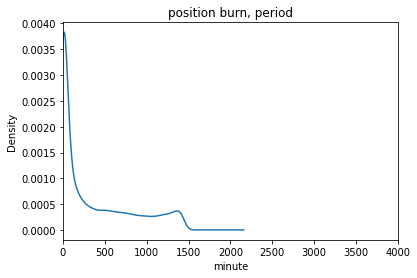

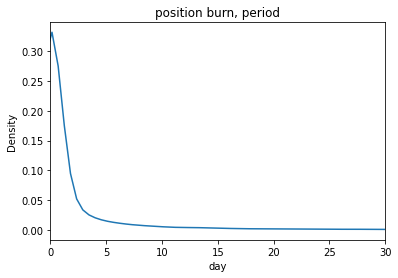

      period_d
0.00       0.0
0.90       5.0
0.95      12.0
0.99      38.0
1.00     276.0


<ipython-input-37-0a26f2f927c7>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time1['date'] = time1['block_timestamp_x'].apply(lambda x: x.strftime("%Y-%m-%d"))


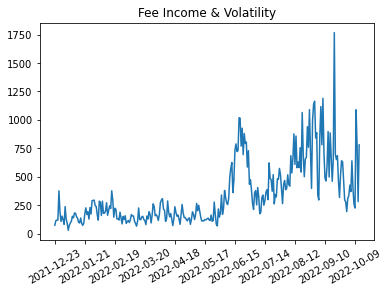

In [37]:
time1 = time.dropna(axis=0)
print(time1.shape)
time1['period'] = (time1['block_timestamp_y'] - time1['block_timestamp_x'])
time1['period_m'] = time1['period'].apply(lambda x: x.seconds/60)
time1['period_d'] = time1['period'].apply(lambda x: x.days)

time1["period_m"].plot.density()
plt.title("position burn, period")
plt.xlabel("minute")
plt.xlim((0,4000))
plt.show()

time1["period_d"].plot.density()
plt.title("position burn, period")
plt.xlim((0,30))
plt.xlabel("day")
plt.show()


print(time1.loc[:,['period_d']].quantile([0,.90,.95,.99,1]))
time1['date'] = time1['block_timestamp_x'].apply(lambda x: x.strftime("%Y-%m-%d"))
df1 = time1.groupby('date').count()
plt.plot(df1['position_id'])
plt.xticks(rotation=30)
ax0 = plt.gca()
ax0.xaxis.set_major_locator(ticker.MultipleLocator(29))
plt.title('Fee Income & Volatility')
plt.show()

所有已经销毁的头寸中， 95%的持有时常都小于12天。
在后期仍然有大量头寸mint，mint截止日期应该在容忍范围内尽可能靠后。

因此我们将2022.9.30日设为mint的截止日期，只考虑2021.12.23-2022.9.30之间mint的头寸。对于所有在2022.10.13日还没有burn的头寸，将其按照2022.10.13 23：59的时间归结burn。

(95202, 6)


Text(0.5, 1.0, 'position burn, period, group by size')

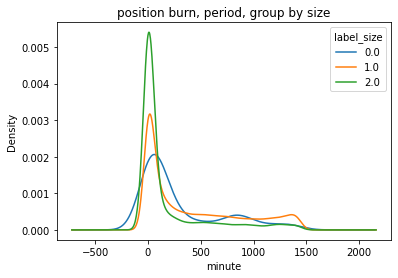

In [38]:
idx = time[time.block_timestamp_x > '2022-10-1'].index.values
time2 = time.drop(idx)
d0 = datetime.datetime(2022,10,13,23,59,59)
time2['block_timestamp_y'] = time2['block_timestamp_y'].fillna(value=d0)
time2 = time2.dropna(axis=0)
print(time2.shape)
time2['period'] = (time2['block_timestamp_y'] - time2['block_timestamp_x'])
time2['period_m'] = time2['period'].apply(lambda x: x.seconds/60)
time2['period_d'] = time2['period'].apply(lambda x: x.days)

time2 = time2.pivot(columns='label_size', values='period_m')
time2.plot.density()
plt.xlabel("minute")
plt.title('position burn, period, group by size')

2021.12.23-2022.9.30内的头寸持有时常
持有资金量越大的投资人，持有时常越短。
所有持有时常基本不超过一天。

In [39]:
mint98['up_percent'] = (mint98['price_upper']/mint98['current_price']) - 1
mint98['low_percent'] = (mint98['price_lower']/mint98['current_price']) - 1
mint98['date'] = mint98['block_timestamp'].apply(lambda x: x.strftime("%Y-%m-%d"))

mint98_day = mint98.loc[:,['date','up_percent','low_percent','price_upper','price_lower']].groupby('date').mean()

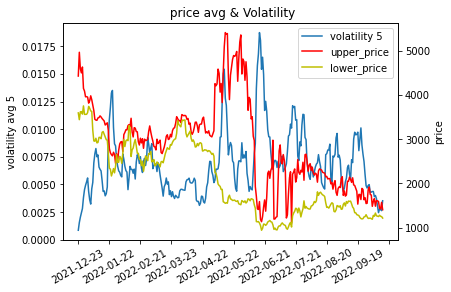

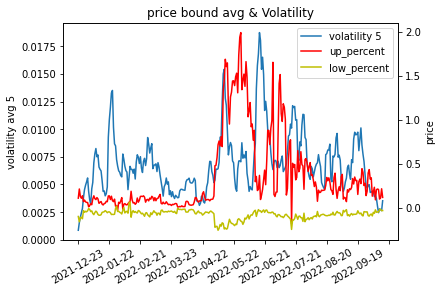

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111)

ln1 = ax.plot(vola['avg5'])
ax.set_ylabel('volatility avg 5')
plt.xticks(rotation=30)

ax2 = ax.twinx()
ln2 = ax2.plot(mint98_day['price_upper'],'r')
ln3 = ax2.plot(mint98_day['price_lower'],'y')
ax2.set_ylabel('price')

lns = ln1 + ln2 + ln3
# labs = [l.get_label() for l in lns]
labs = ['volatility 5','upper_price','lower_price']
ax.legend(lns, labs, loc=0)

ax0 = plt.gca()
ax0.xaxis.set_major_locator(ticker.MultipleLocator(30))
plt.title(' price avg & Volatility')
plt.show()





fig = plt.figure()
ax = fig.add_subplot(111)

ln1 = ax.plot(vola['avg5'])
ax.set_ylabel('volatility avg 5')
plt.xticks(rotation=30)

ax2 = ax.twinx()
ln2 = ax2.plot(mint98_day['up_percent'],'r')
ln3 = ax2.plot(mint98_day['low_percent'],'y')
ax2.set_ylabel('price')

lns = ln1 + ln2 + ln3
# labs = [l.get_label() for l in lns]
labs = ['volatility 5','up_percent','low_percent']
ax.legend(lns, labs, loc=0)

ax0 = plt.gca()
ax0.xaxis.set_major_locator(ticker.MultipleLocator(30))
plt.title('price bound avg & Volatility')
plt.show()



In [ ]:
整体上来看，波动率与做市范围正相关。
投资者看涨以太坊，这体现在更高的价格上界

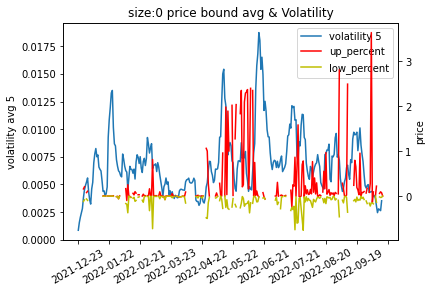

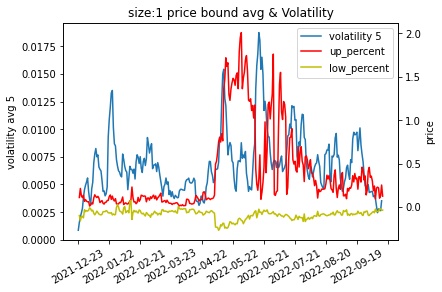

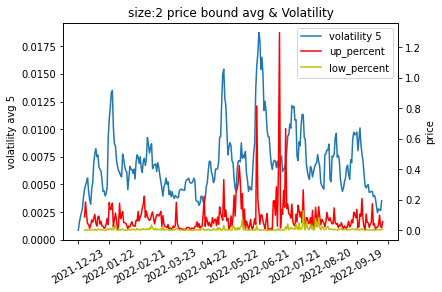

In [41]:
mint98_size = mint98.loc[:,['label_size','date','up_percent','low_percent','price_upper','price_lower']].groupby('label_size')
df_dates = pd.DataFrame({'date':dates})

for n, df in mint98_size:
    df = df.groupby('date').mean()
    df = pd.merge(df_dates, df, how='left', left_on='date',right_index=True)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ln1 = ax.plot(vola['avg5'])
    ax.set_ylabel('volatility avg 5')
    plt.xticks(rotation=30)
    
    ax2 = ax.twinx()
    ln2 = ax2.plot(df['up_percent'],'r')
    ln3 = ax2.plot(df['low_percent'],'y')
    ax2.set_ylabel('price')
    
    lns = ln1 + ln2 + ln3
    # labs = [l.get_label() for l in lns]
    labs = ['volatility 5','up_percent','low_percent']
    ax.legend(lns, labs, loc=0)
    
    ax0 = plt.gca()
    ax0.xaxis.set_major_locator(ticker.MultipleLocator(30))
    plt.title('size:'+str(n)+' price bound avg & Volatility')
    plt.show()

In [ ]:
小额LP只在波动率高的日子出现，有一定滞后性，做市范围较大，lower， upper bound 有一定的对称性。
且早期，小额lp基本没有。小额投资者可能还不太关注这个市场。

中额LP做市范围最大，主要赚取手续费收益。

大额LP：上界与波动率相关性很高，且价格下届往往高于当前价格。